# Interactive Jupyter Notebook to Learn about faster Optimizers and visualize them

## Setup
1. Start by executing the ``import`` Block to see, if the required packages are installed. Install missing ones until you can successfully execute the block
2. Go through the Sections. Do the following steps for each section
    1. Execute the `Setup` block. This creates all necessary functions for the section
    2. Work on the `Task` block
    3. Visualize and Test using the `Visualize` Block

### Import Block

In [1]:
from random import randint
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from typing import Tuple, List, Callable, Any

### General Setup

In [2]:
# Defining Different Functions with different shapes
def steep_valley_function():
    def f(x, y):
        # Define a function with a steeper gradient in the y-direction
        return 0.5 * x**2 + 2 * y**2

    def grad(x, y):
        # Compute the gradient of the function
        grad_x = x  # Gradient with respect to x
        grad_y = 4 * y  # Gradient with respect to y, steeper than x
        return np.array([grad_x, grad_y])

    x = np.linspace(-20, 20, 400)
    y = np.linspace(-20, 20, 400)
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    return X, Y, Z, f, grad


def l_shaped_valley_function():
    def f(x, y):
        # Creating an L-shaped valley with a sharp turn
        # Define the valley with two different linear regions
        # Horizontal part (x > y), Vertical part (x <= y)
        return np.where(x > y, (y + 20) ** 2 + x, (x + 20) ** 2 + y)

    def grad(x, y):
        # Gradient of the L-shaped function, changing at x = y
        # Horizontal part gradient
        grad_x = np.where(x > y, 1, 2 * (x + 20))
        grad_y = np.where(x > y, 2 * (y + 20), 1)
        return np.array([grad_x, grad_y])

    x = np.linspace(-50, 20, 400)
    y = np.linspace(-50, 20, 400)
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    return X, Y, Z, f, grad


def asymmetric_convex_function():
    def f(x, y):
        # Scale the coefficients to increase the depth and curvature differences
        return (
            0.3 * (x - 10) ** 2
            + 0.2 * (y - 10) ** 2
            + 1.1 * (x + 10) ** 2
            + 1 * (y + 10) ** 2
        )

    def grad(x, y):
        # Adjusted gradient for the scaled function
        grad_x = 0.6 * (x - 10) + 2.2 * (
            x + 10
        )  # Increased coefficients for the gradients
        grad_y = 0.4 * (y - 10) + 2 * (y + 10)
        return np.array([grad_x, grad_y])

    x = np.linspace(-20, 20, 400)
    y = np.linspace(-20, 20, 400)
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    return X, Y, Z, f, grad


def symmetric_convex_function():
    def f(x, y):
        return x**2 + y**2  # Z as a function of X and Y

    def grad(x, y):
        grad_x = 2 * x
        grad_y = 2 * y
        return np.array([grad_x, grad_y])

    x = np.linspace(-20, 20, 100)
    y = np.linspace(-20, 20, 100)
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    min_coord = [0,0]
    return X, Y, Z, f, grad

# defining General optimize function to standardize paramters and return
def optimize(
    # parent method to call all other optimization methods
    optimizer_type="Regular",
    function=steep_valley_function,
    steps=10,
    lr=0.1,
    beta1=0.9,
    beta2=0.999,
    cur_pos=np.array([15, 18]),
    print_res=False,
) -> Tuple[Callable[[float, float], float], List[np.ndarray], List[float], str]:

    # Choose and run the optimizer
    # they always return this way: X Y Z positions,
    if optimizer_type == "Regular":
        return regular_gradient_descent(function, steps, lr, cur_pos, print_res)
    elif optimizer_type == "Momentum":
        return momentum_gradient_descent(function, steps, lr, beta1, cur_pos, print_res)
    elif optimizer_type == "Nesterov":
        return nesterov_gradient_descent(function, steps, lr, beta1, cur_pos, print_res)
    elif optimizer_type == "AdaGrad":
        return adagrad_gradient_descent(function, steps, lr, cur_pos, print_res)
    elif optimizer_type == "RMSProp":
        return rmsprop_gradient_descent(function, steps, lr, beta1, cur_pos, print_res)
    elif optimizer_type == "Adam":
        return adam_gradient_descent(
            function, steps, lr, beta1, beta2, cur_pos, print_res
        )


def optimize_multiple(
    optimizers=["Regular", "momentum"],
    function=steep_valley_function,
    steps=10,
    lr=0.1,
    beta1=0.9,
    beta2=0.999,
    cur_pos=np.array([15, 18]),
    print_res=False,
):
    results = []
    for optimizer in optimizers:
        results.append(
            optimize(optimizer, function, steps, lr, beta1, beta2, cur_pos, print_res)
        )
    return results

# Plotting Function that takes a list of results and Returns a Plot (not yet interactive)
def plot_optimization_path(optimizer_results):
    fig = plt.figure(figsize=(24, 8))
    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    ax2 = fig.add_subplot(1, 2, 2)  # 2D plot for top-down heatmap view

    # Assuming all optimizers use the same function landscape
    f = optimizer_results[0][0]  # Extract function handle from first result
    x_range = np.linspace(-20, 20, 1000)
    y_range = np.linspace(-20, 20, 1000)
    X, Y = np.meshgrid(x_range, y_range)
    Z = f(X, Y)

    # Find the minimum value and its coordinates
    min_z = np.min(Z)
    min_pos = np.where(Z == min_z)
    min_x = X[min_pos][0]
    min_y = Y[min_pos][0]

    # Plot the 3D surface
    ax1.plot_surface(X, Y, Z, alpha=0.5, cmap='viridis', edgecolor='none')
    ax1.set_title('3D View - Optimization Paths')

    # Mark the minimum point on the 3D plot
    ax1.scatter(min_x, min_y, min_z, marker='8', color='black', s=30, alpha=0.5, label="Minumum")
    #ax1.text(min_x, min_y, min_z, f'({min_x:.2f}, {min_y:.2f}, {min_z:.2f})', color='red')

    # Plot the 2D heatmap
    ax2.contourf(X, Y, Z, levels=100, cmap='viridis')
    ax2.set_title('Top-Down View (2D) - Optimization Paths')
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')

    ax2.scatter(min_x, min_y, marker='8', color='black', linewidths=5, alpha=0.5, label="Minumum")


    # Define specific colors for each optimizer
    color_map = {
        "Regular": "red",
        "Momentum": "blue",
        "Nesterov": "green",
        "AdaGrad": "orange",
        "RMSProp": "purple",
        "Adam": "black"
    }

    # Plot the paths for each optimizer
    for idx, (f, positions, z_values, name) in enumerate(optimizer_results):
        positions_array = np.array(positions)
        color = color_map.get(name, "gray")  # Default to gray if name not found
        
        # 3D Path
        ax1.scatter(
            positions_array[:, 0], positions_array[:, 1], z_values,
            color=color, s=50, label=name
        )
        
        # 2D Path
        ax2.plot(
            positions_array[:, 0],
            positions_array[:, 1],
            marker='o',
            color=color,
            markersize=5,
            linestyle='--',
            linewidth=2,
            label=name
        )

    ax1.set_xlim(-20,20)
    ax1.set_ylim(-20,20)

    ax2.set_xlim(-20,20)
    ax2.set_ylim(-20,20)

    ax1.legend()  # Show legends to label different optimizer paths
    ax2.legend()

    plt.show()

In [3]:
# Build Method that takes plotting method and adds interactive elements
def visualize_optimizer(optimizer_multiselect_options=["Regular", "Momentum", "Nesterov", "AdaGrad", "RMSProp", "Adam"]):
    # Define Optimizer Setting Widgets
    optimizer_settings = {
        "Regular": {"lr": widgets.FloatSlider(value=0.1, min=0, max=2, step=0.01, description="Learning Rate")},
        "Momentum": {
            "lr": widgets.FloatSlider(value=0.1, min=0, max=2, step=0.01, description="Learning Rate"),
            "beta1": widgets.FloatSlider(value=0.9, min=0, max=1, step=0.01, description="Beta1 Factor")
        },
        "Nesterov": {
            "lr": widgets.FloatSlider(value=0.1, min=0, max=2, step=0.01, description="Learning Rate"),
            "beta1": widgets.FloatSlider(value=0.9, min=0, max=1, step=0.01, description="Beta1 Factor")
        },
        "AdaGrad": {"lr": widgets.FloatSlider(value="0.1", min=0, max=2, step=0.01, description="Learning Rate")},
        "RMSProp": {
            "lr": widgets.FloatSlider(value="0.1", min=0, max=2, step=0.01, description="Learning Rate"),
            "beta1": widgets.FloatSlider(value=0.9, min=0, max=1, step=0.01, description="Beta1 Factor")
        },
        "Adam": {
            "lr": widgets.FloatSlider(value="0.1", min=0, max=2, step=0.01, description="Learning Rate"),
            "beta1": widgets.FloatSlider(value=0.9, min=0, max=1, step=0.01, description="Beta1 Factor"),
            "beta2": widgets.FloatSlider(value=0.999, min=0, max=1, step=0.001, description="Beta2 Factor")
        }
    }

    # Filter the optimizer_settings based on optimizer_multiselect_options
    optimizer_settings = {key: value for key, value in optimizer_settings.items() if key in optimizer_multiselect_options}

    # Define Function Selection and Initial Position Widgets
    func_dropdown = widgets.Dropdown(
        description="Function",
        options=[
            ("Steep Valley Function", steep_valley_function),
            ("Symmetric Convex Function", symmetric_convex_function),
            ("Asymmetric Convex Function", asymmetric_convex_function),
            ("L-shaped Valley Function", l_shaped_valley_function),
        ],
        layout=widgets.Layout(width="100%"),
    )
    x_slider = widgets.IntSlider(value=15, min=-20, max=20, step=1, description="Starting X", layout=widgets.Layout(width="100%"))
    y_slider = widgets.IntSlider(value=10, min=-20, max=20, step=1, description="Starting Y", layout=widgets.Layout(width="100%"))
    steps_slider = widgets.IntSlider(value=10, min=1, max=30, step=1, description="Steps", layout=widgets.Layout(width="100%"))

    # Define Optimizer Toggle and Multi-Select Widgets
    optimizer_multiselect = widgets.SelectMultiple(
        description="Optimizers",
        options=list(optimizer_settings.keys()),
        value=[list(optimizer_settings.keys())[0]],
        layout=widgets.Layout(width="100%"),
    )

    # Optimizer Toggle for Parameter Configuration
    optimizer_toggle = widgets.ToggleButtons(
        description="Configure Optimizer",
        options=list(optimizer_settings.keys()),
        value=list(optimizer_settings.keys())[0],
        layout=widgets.Layout(width="100%")
    )

    # Placeholder for Dynamic Optimizer Settings
    optimizer_settings_box = widgets.VBox()

    # Function to Update Optimizer Settings Display
    def update_optimizer_settings(change):
        selected_optimizer = change['new']
        boxes = [widgets.Label(value=selected_optimizer)]
        for setting, widget in optimizer_settings[selected_optimizer].items():
            boxes.append(widget)
        optimizer_settings_box.children = boxes

    optimizer_toggle.observe(update_optimizer_settings, names='value')

    # Initial Setup for Optimizer Settings Display
    update_optimizer_settings({'new': optimizer_toggle.value})

    # Function to Update Plot
    def update_plot(optimizers, function, steps, initialX, initialY, **kwargs):
        cur_pos = np.array([initialX, initialY])
        results = []
        for optimizer in optimizers:
            params = {key: kwargs.get(f'{optimizer}_{key}') for key in optimizer_settings[optimizer].keys()}
            results.append(optimize(optimizer, function, steps, cur_pos=cur_pos, **params))
        plot_optimization_path(results)

    # Interactive Output
    out = widgets.interactive_output(
        update_plot,
        {
            "optimizers": optimizer_multiselect,
            "function": func_dropdown,
            "steps": steps_slider,
            "initialX": x_slider,
            "initialY": y_slider,
            **{f'{opt}_{param}': widget for opt, settings in optimizer_settings.items() for param, widget in settings.items()}
        },
    )

    # Display UI
    ui = widgets.VBox([
        widgets.HBox([x_slider, y_slider]),
        widgets.HBox([steps_slider, func_dropdown]),
        optimizer_multiselect,
        optimizer_toggle,
        optimizer_settings_box
    ])

    display(ui, out)

## Section 1: Regular vs Momentum Optimizer

## Setup
Hier werden die Functions für den Step und Gradient Descent der zwei ersten Optimizer gesetzt.

In [4]:
# --------------------------------------------------------------
# Regular Gradient Descent Step and Function


def regular_gradient_step(pos, lr, grad):
    return pos - lr * grad(*pos)


def regular_gradient_descent(
    function=steep_valley_function,
    steps=1,
    lr=0.1,
    cur_pos=np.array([15, 18]),
    print_res=False,
) -> Tuple[Callable[[float, float], float], List[np.ndarray], List[float], str]:
    X, Y, Z, f, grad = function()
    positions = [cur_pos]
    z_values = [f(cur_pos[0], cur_pos[1])]

    for i in range(steps):
        cur_pos = regular_gradient_step(cur_pos, lr, grad)
        cur_pos = np.clip(cur_pos, -20, 20) # added to prevent weird plots with points out of bound
        positions.append(cur_pos)
        cur_z = f(cur_pos[0], cur_pos[1])
        z_values.append(cur_z)
        if print_res:
            print(f"Step {i}: X, Y = {cur_pos}, Z = {cur_z}")

    return (f, positions, z_values, "Regular")


# --------------------------------------------------------------
# Momentum Gradient Descent Step and Function


def momentum_step(pos, lr, beta, momentum, grad):
    gradient = grad(*pos)
    momentum = beta * momentum - lr * gradient
    pos = pos + momentum

    return momentum, pos


def momentum_gradient_descent(
    function=steep_valley_function,
    steps=1,
    lr=0.1,
    beta1=0.9,
    cur_pos=np.array([15, 18]),
    print_res=False,
):
    X, Y, Z, f, grad = function()
    momentum = np.zeros(2)
    positions = [cur_pos]
    z_values = [f(cur_pos[0], cur_pos[1])]

    for i in range(steps):
        momentum, cur_pos = momentum_step(cur_pos, lr, beta1, momentum, grad)
        cur_pos = np.clip(cur_pos, -20, 20) # added to prevent weird plots with points out of bound
        positions.append(cur_pos)
        cur_z = f(cur_pos[0], cur_pos[1])
        z_values.append(cur_z)
        if print_res:
            print(f"Step {i}: X, Y = {cur_pos}, Z = {cur_z}")

    return (f, positions, z_values, "Momentum")

## Task / Visualize
The Task in Section 1 is to play around with the Regular and Momentum optimizers and get comfortable using the visualizer tool.

Try answering these Questions (for yourself):
- How do the Optimizers behave for different `Starting X` and `Starting Y` values?
- How does the Optimizers behaviour change, when the ``learning rate`` is adjusted?
- What part of the Optimizers behaviour is influenced by the ``Beta1 Factor``?
- How does the Optimizer behave in different ``Functions``?

Tips:
- You can choose Multiple Optimizers at once by holding down the Shift Key during selection

In [5]:
visualize_optimizer(optimizer_multiselect_options=["Regular", "Momentum"])

Output()

## Section 2: Nesterov Accelerated Gradient (NAG)

### (Setup)
Diese Section bedarf keines weiteren Setup

### Task
Your task is, to define the step function for the Nesterov Accelerated Gradient Descent (short, NAG).

Tips:
- Look closely at the mathematical definition
- Orient yourself at the Momentum Optimizer's Step Function

Nesterov Equation:
$$ m \leftarrow \beta m - \eta \nabla_{\theta} J(\theta + \beta m) $$
$$ \theta \leftarrow \theta + m $$

In [6]:
def nesterov_step(pos, lr, beta, momentum, grad):
    # TODO Implement the Nesterov Step function
    # Important: the parameter grad is a Function giving you the value of the gradient at position x when calling grad(*x)
    return pos, momentum


def nesterov_gradient_descent(
    function=steep_valley_function,
    steps=1,
    lr=0.1,
    beta1=0.9,
    cur_pos=np.array([15, 18]),
    print_res=False,
):
    X, Y, Z, f, grad = function()
    momentum = np.zeros(2)  # Initial momentum vector
    positions = [cur_pos]
    z_values = [f(cur_pos[0], cur_pos[1])]

    for i in range(steps):
        cur_pos, momentum = nesterov_step(cur_pos, lr, beta1, momentum, grad)
        cur_pos = np.clip(cur_pos, -20, 20) # added to prevent weird plots with points out of bound
        positions.append(cur_pos.copy())  # Append the new position after update
        cur_z = f(cur_pos[0], cur_pos[1])
        z_values.append(cur_z)
        if print_res:
            print(f"Step {i}: X, Y = {cur_pos}, Z = {cur_z}")

    # Use the generic plotting function to visualize the path
    return (f, positions, z_values, "Nesterov")

### Visualize

In [7]:
visualize_optimizer(optimizer_multiselect_options=['Nesterov'])

Output()

## Section 3: AdaGrad, RMSProp und Adam

### Task
Your task is to visualize the s variable for both Adagrad and RMSProp
What difference is noticeable, why is that the case?

### Formula:
AdaGrad
$$ s \leftarrow s + \nabla_{\theta} J(\theta)^2 $$
$$ \theta \leftarrow \theta - \frac{\eta}{\sqrt{s + \epsilon}} \cdot \nabla_{\theta} J(\theta)  $$

RMSProp 
$$ \mathbf{s} \leftarrow \beta \mathbf{s} + (1-\beta) \nabla_{\theta} J(\theta) \otimes \nabla_{\theta} J(\theta) $$
$$ \theta \leftarrow \theta - \eta \nabla_{\theta} J(\theta) \oslash \sqrt{\mathbf{s} + \epsilon} $$

Tips:
- Use the global lists adagrad_s and rmsprop_s
- The Plot Functionality is already implemented below


In [8]:
adagrad_s = []
rmsprop_s = []

def adagrad_step(pos, lr, grad, s):
    epsilon = 10 ** (-10)  # set to different value if needed
    gradient = grad(*pos)
    s += gradient**2  # Accumulate squared gradients
    adjusted_lr = lr / (np.sqrt(s) + epsilon)
    pos = pos - adjusted_lr * gradient
    return pos, s


def adagrad_gradient_descent(
    function=steep_valley_function,
    steps=10,
    lr=0.1,
    cur_pos=np.array([15, 18]),
    print_res=False,
):
    X, Y, Z, f, grad = function()
    positions = [cur_pos.copy()]
    z_values = [f(cur_pos[0], cur_pos[1])]
    global adagrad_s
    s = np.zeros(2)  # Initialize sum of squares of gradients
    adagrad_s = []
    for i in range(steps):
        cur_pos, s = adagrad_step(cur_pos, lr, grad, s)
        adagrad_s.append(s.copy())
        cur_pos = np.clip(cur_pos, -20, 20) # added to prevent weird plots with points out of bound
        positions.append(cur_pos.copy())  # Ensure a deep copy for immutability in list
        cur_z = f(cur_pos[0], cur_pos[1])
        z_values.append(cur_z)
        if print_res:
            print(f"Step {i}: X = {cur_pos[0]}, Y = {cur_pos[1]}, Z = {cur_z}")

    return (f, positions, z_values, "AdaGrad")


def rmsprop_step(pos, lr, grad, s, beta=0.9, epsilon=1e-8):
    gradient = grad(*pos)
    s = beta * s + (1 - beta) * gradient**2
    pos = pos - (lr * gradient / (np.sqrt(s + epsilon)))
    return pos, s

    # # alternative function with adjusted learning rate
    # gradient = grad(*pos)
    # s = beta * s + (1 - beta) * gradient ** 2  # Update accumulation of squared gradients
    # adjusted_lr = lr / (np.sqrt(s) + epsilon)  # Adjust learning rate
    # pos = pos - adjusted_lr * gradient  # Update position
    # return pos, s


def rmsprop_gradient_descent(
    function=steep_valley_function,
    steps=10,
    lr=0.1,
    beta1=0.9,
    cur_pos=np.array([15, 18]),
    print_res=False,
):
    X, Y, Z, f, grad = function()
    positions = [cur_pos.copy()]
    z_values = [f(cur_pos[0], cur_pos[1])]
    global rmsprop_s
    s = np.zeros_like(cur_pos)  # Initialize the RMS accumulation variable
    rmsprop_s = []
    for i in range(steps):
        cur_pos, s = rmsprop_step(
            cur_pos, lr, grad, s, beta1
        )  # Update position and RMS
        rmsprop_s.append(s.copy())
        cur_pos = np.clip(cur_pos, -20, 20) # added to prevent weird plots with points out of bound
        positions.append(cur_pos.copy())  # Ensure a deep copy for immutability in list
        cur_z = f(cur_pos[0], cur_pos[1])
        z_values.append(cur_z)
        if print_res:
            print(f"Step {i}: X = {cur_pos[0]}, Y = {cur_pos[1]}, Z = {cur_z}")

    return (f, positions, z_values, "RMSProp")


def adam_step(pos, lr, grad, m, v, t, beta1=0.9, beta2=0.999, epsilon=1e-8):
    gradient = grad(*pos)
    m = beta1 * m + (1 - beta1) * gradient  # Update biased first moment estimate
    v = beta2 * v + (1 - beta2) * gradient**2  # Update biased second moment estimate
    m_hat = m / (1 - beta1**t)  # Compute bias-corrected first moment estimate
    v_hat = v / (1 - beta2**t)  # Compute bias-corrected second moment estimate
    pos = pos - lr * m_hat / (np.sqrt(v_hat) + epsilon)  # Update parameters
    return pos, m, v


def adam_gradient_descent(
    function=steep_valley_function,
    steps=10,
    lr=0.1,
    beta1=0.9,
    beta2=0.99,
    cur_pos=np.array([15, 18]),
    print_res=False,
):
    X, Y, Z, f, grad = function()
    positions = [cur_pos.copy()]
    z_values = [f(cur_pos[0], cur_pos[1])]

    m = np.zeros_like(cur_pos)  # Initialize first moment vector
    v = np.zeros_like(cur_pos)  # Initialize second moment vector
    t = 0  # Initialize timestep

    positions = [cur_pos.copy()]  # Store positions for plotting

    for i in range(1, steps + 1):
        t += 1  # Increment time step
        cur_pos, m, v = adam_step(
            cur_pos, lr, grad, m, v, t, beta1, beta2
        )  # Adam optimization step
        cur_pos = np.clip(cur_pos, -20, 20) # added to prevent weird plots with points out of bound
        positions.append(cur_pos.copy())  # Ensure a deep copy for immutability in list
        cur_z = f(cur_pos[0], cur_pos[1])
        z_values.append(cur_z)
        if print_res:
            print(f"Step {i}: X = {cur_pos[0]}, Y = {cur_pos[1]}, Z = {cur_z}")

    # Use the plot function to visualize the optimization path
    return (f, positions, z_values, "Adam")

In [9]:
visualize_optimizer(optimizer_multiselect_options=["AdaGrad", "RMSProp"])

Output()

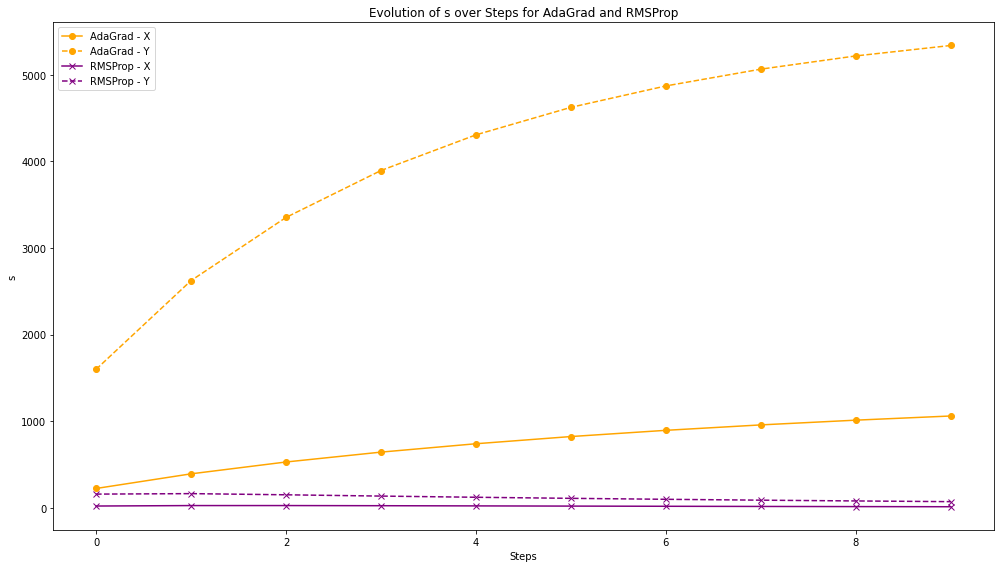

In [10]:
if not np.array(adagrad_s).any():
    raise SystemExit('Run the optimizers first')

# Convert lists to arrays for easier plotting
adagrad_s = np.array(adagrad_s)
rmsprop_s = np.array(rmsprop_s)

# Plot the evolution of s for AdaGrad and RMSProp
plt.figure(figsize=(14, 8))

# Plot for both dimensions together
plt.plot(adagrad_s[:, 0], label='AdaGrad - X', marker='o', color='orange')
plt.plot(adagrad_s[:, 1], label='AdaGrad - Y', marker='o', linestyle='dashed', color='orange')
plt.plot(rmsprop_s[:, 0], label='RMSProp - X', marker='x', color='purple')
plt.plot(rmsprop_s[:, 1], label='RMSProp - Y', marker='x', linestyle='dashed', color='purple')

plt.title('Evolution of s over Steps for AdaGrad and RMSProp')
plt.xlabel('Steps')
plt.ylabel('s')
plt.legend()

plt.tight_layout()
plt.show()

## Section X: Vergleich aller Optimierer
In dieser Section sollen noch einmal alle Optimierer interaktiv miteinander verglichen werden.

Die Aufgabe ist es XX mit dem Gesamtbild herumzuspielen?(keine gute idee, irgendwie wettkampf einbauen. Vielleicht, indem wir ne Funktion bauen, die die Nähe zum Ziel ausgibt. Dann kann man gucken, wer in einer bestimmten Anzahl Schritte möglichst nahe gekommen ist)

In [11]:
visualize_optimizer()

Output()